# TEMPERATURE COMPARISON

The [ECA dataset](https://www.ecad.eu/dailydata/index.php) contains series of daily observations at meteorological stations throughout Europe and the Mediterranean.

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display
from matplotlib import cm, colors

sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

In [144]:
count_daily = pd.read_csv('../../data/all_species_count_daily.csv',
                          parse_dates=['date'])

# NOTE: remove high tmp values!
count_daily['tmp'].values[count_daily['tmp'] > 50] = np.nan

# get hex color codes of Dark2 matplotlib colormap
cmap = cm.get_cmap('Dark2', 8)
hex = []
for i in range(cmap.N):
    rgba = cmap(i)
    # convert rgb(a) to hex
    hex.append(colors.rgb2hex(rgba))

In [145]:
# read daily temperature data from weather stations and merge into single dataframe
def read_eca_stations(files, names):

    df_final = pd.DataFrame()
    
    for i, file in enumerate(files):
        eca = pd.read_csv( # import txt file                            
            filepath_or_buffer=f'../../data/ECA&D/{file}.txt',
            skiprows=20,
            parse_dates=[2],
            dtype={'TX': np.float64},
            na_values=-9999
        )    
        eca.columns = eca.columns.str.strip()
        eca['TX'] = eca['TX'] / 10 # temperature is stored in °C * 10
        eca = (eca.set_index('DATE')
                  .drop(columns=['STAID', 'SOUID', 'Q_TX'])
                  .rename(columns={'TX': names[i]}))
        df_final = pd.concat([df_final, eca], axis='columns')
    return df_final

df_weather_stations = read_eca_stations(
    ['TX_STAID000077', 'TX_STAID000201', 'TX_STAID000199', 'TX_STAID001012'],
    ['Kaliningrad',    'Klaipeda',       'Liepaja',        'Nida']
)
df_weather_stations

,Kaliningrad,Klaipeda,Liepaja,Nida
DATE,,,,
1881-01-01,NaN,NaN,0.0,NaN
1881-01-02,NaN,NaN,0.0,NaN
1881-01-03,NaN,NaN,0.0,NaN
1881-01-04,NaN,NaN,0.0,NaN
1881-01-05,NaN,NaN,0.0,NaN
...,...,...,...,...
2022-03-27,NaN,NaN,4.6,NaN
2022-03-28,NaN,NaN,7.2,NaN
2022-03-29,NaN,NaN,4.7,NaN


In [146]:
temp_records = (['Kaliningrad', 'Klaipeda', 'Liepaja'] # initial weather stations
                + ['Fringilla'] # site of insect count
                + ['Nida']) # weather stations that were added later-on
 
# join with fringilla insect data
tmp_comparison = count_daily.join(
    df_weather_stations,
    on='date',
    how='inner'
).reset_index(drop=True).rename(
    columns={'tmp': 'Fringilla'}
)

# convert to long format and remove non-temperature data
tmp_comparison = tmp_comparison.melt(
    id_vars=['date', 'year', 'month', 'day'],
    value_vars=temp_records,
    var_name='data_origin',
    value_name='tmp'
).drop_duplicates().reset_index(drop=True)
tmp_comparison

,date,year,month,day,data_origin,tmp
0,1982-04-01,1982,4,1,Kaliningrad,9.5
1,1982-04-02,1982,4,2,Kaliningrad,15.5
2,1982-04-03,1982,4,3,Kaliningrad,17.1
3,1982-04-04,1982,4,4,Kaliningrad,9.9
4,1982-04-05,1982,4,5,Kaliningrad,11.5
...,...,...,...,...,...,...
41920,2020-10-28,2020,10,28,Nida,NaN
41921,2020-10-29,2020,10,29,Nida,NaN
41922,2020-10-30,2020,10,30,Nida,NaN
41923,2020-10-31,2020,10,31,Nida,NaN


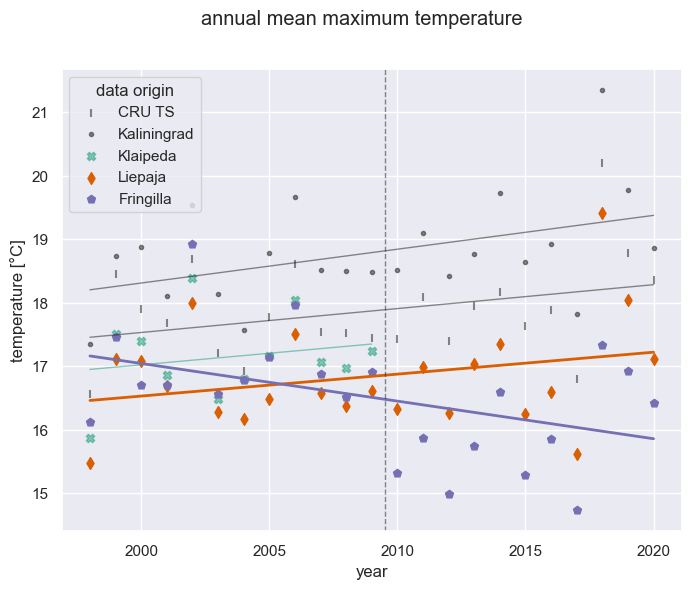

In [147]:
# get cru ts tmp data
%store -r cru_tmp_yr

# compute annual mean MAX temperature
data = (tmp_comparison[tmp_comparison.year >= 1998]
        .groupby(['year', 'data_origin'], as_index=False)
        ['tmp'].mean())

# plotting...
fig, ax = plt.subplots(figsize=(8, 6))
m = ['.', 'X', 'd', 'p']
c = ['k', hex[0], hex[1], hex[2]]
alpha = [0.5, 0.5, 1, 1]
lw = [1, 1, 2, 2]

# cru ts
sns.regplot(x=np.arange(1998,2021), y=cru_tmp_yr,
            line_kws={'linewidth': 1, 'alpha': 0.5},
            scatter_kws={'alpha': 0.5},
            label='CRU TS',
            ax=ax, ci=None, color='k', marker='|')

# weather stations & fringilla
for i, loc in enumerate(temp_records[:-1]): # excluding Nida weather station
    sns.regplot(
        data=data[data['data_origin'] == loc],
        x='year', y='tmp',
        line_kws={'linewidth': lw[i], 'alpha': alpha[i]},
        scatter_kws={'alpha': alpha[i]},
        label=loc, color=c[i],
        ax=ax, ci=None, marker=m[i])

ax.legend(title='data origin', loc='upper left')
ax.set_ylabel('temperature [°C]')
ax.axvline(x=2009.5, ls='--', lw=1, c='k', alpha=0.5)
fig.suptitle('annual mean maximum temperature')
fig.savefig('../figs/temperature-comparison.png', 
            dpi=600, bbox_inches='tight')

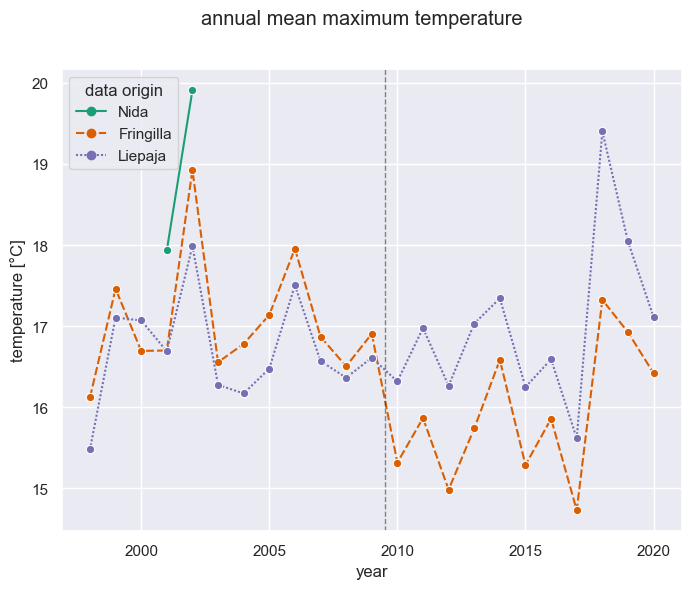

In [148]:
# compare tmp records of Fringilla and Nida (closest station, but isn't included
# in CRU TS and thus wasn't initially considered)

sns_order = ['Nida', 'Fringilla', 'Liepaja']

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(
    data=data[data.data_origin.str.contains('Fringilla|Nida|Liepaja')],
    x='year', y='tmp', hue='data_origin', style='data_origin',
    markers = ['o']*3, ax=ax,
    hue_order = sns_order, style_order = sns_order,
)
ax.legend(title='data origin', loc='upper left')
ax.set_ylabel('temperature [°C]')
ax.axvline(x=2009.5, ls='--', lw=1, c='k', alpha=0.5)
fig.suptitle('annual mean maximum temperature')
fig.savefig('../figs/temperature-comparison-nida.png', 
            dpi=600, bbox_inches='tight')

In [149]:
# compute difference of Fringilla and Liepaja
daily_comp = tmp_comparison.pivot(
    index=['date', 'year'], 
    columns='data_origin', values='tmp'
).drop(
    columns=['Kaliningrad', 'Klaipeda']
).reset_index()
daily_comp.columns.name = None
daily_comp['diff'] = daily_comp['Fringilla'] - daily_comp['Liepaja']
daily_comp

,date,year,Fringilla,Liepaja,Nida,diff
0,1982-04-01,1982,NaN,5.7,NaN,NaN
1,1982-04-02,1982,NaN,6.6,NaN,NaN
2,1982-04-03,1982,NaN,12.6,NaN,NaN
3,1982-04-04,1982,NaN,5.4,NaN,NaN
4,1982-04-05,1982,NaN,6.7,NaN,NaN
...,...,...,...,...,...,...
8380,2020-10-28,2020,NaN,12.2,NaN,NaN
8381,2020-10-29,2020,NaN,13.0,NaN,NaN
8382,2020-10-30,2020,NaN,11.1,NaN,NaN
8383,2020-10-31,2020,NaN,8.6,NaN,NaN


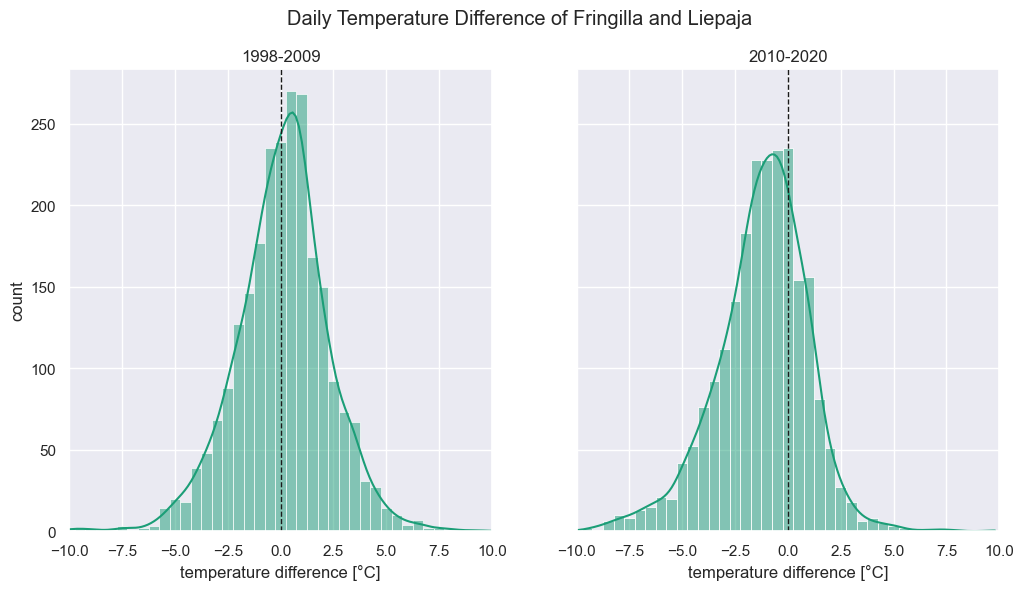

In [150]:
def plot_histo(ax, interval):
    sns.histplot(
        data=daily_comp[daily_comp['year'].isin(interval)], 
        x='diff', stat='count', binwidth=0.5, binrange=(-10.25, 10.25),
        kde=True, ax=ax
    )
    ax.set_xlim(-10,10)
    ax.set_xlabel('temperature difference [°C]')
    ax.set_ylabel('count')
    ax.set_title(f'{interval[0]}-{interval[-1]}')
    ax.axvline(x=0, c='k', ls='--', lw=1)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6))

plot_histo(axs[0], np.arange(1998,2010))
plot_histo(axs[1], np.arange(2010,2020+1))

fig.suptitle('Daily Temperature Difference of Fringilla and Liepaja')

fig.savefig('../figs/temperature-difference.png', 
            dpi=600, bbox_inches='tight')

Text(0.5, 0.98, 'Daily Temperature Difference of Fringilla and Liepaja')

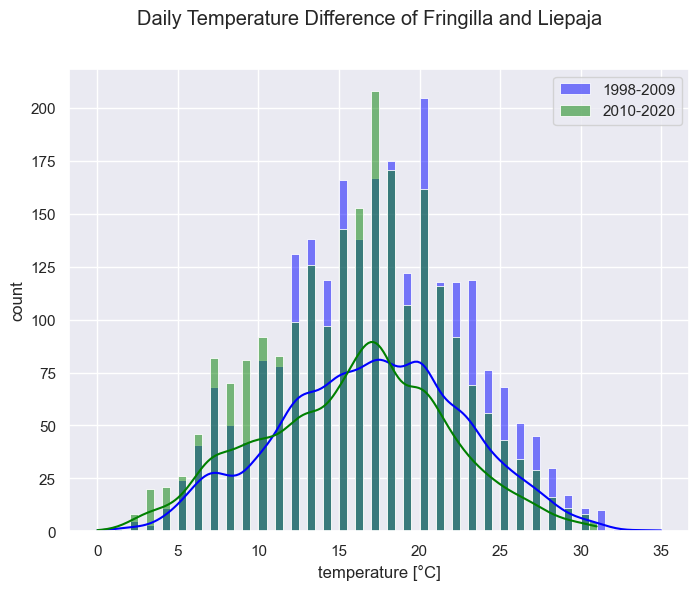

In [151]:
def plot_histo(ax, interval, c):
    sns.histplot(
        data=daily_comp[daily_comp['year'].isin(interval)], 
        x='Fringilla', stat='count', binwidth=0.5, color=c,
        kde=True, ax=ax, label=f'{interval[0]}-{interval[-1]}',
        alpha=0.5, kde_kws={'bw_adjust': 0.75}
    )
    ax.set_xlabel('temperature [°C]')
    ax.set_ylabel('count')

fig, ax = plt.subplots(figsize=(8,6))

plot_histo(ax, np.arange(1998,2010), 'blue')
plot_histo(ax, np.arange(2010,2020+1), 'green')

ax.legend()
fig.suptitle('Daily Temperature Difference of Fringilla and Liepaja')

### DIVING INTO DISTRIBUTION OF TEMPERATURE RECORDINGS

i.e., random plots...

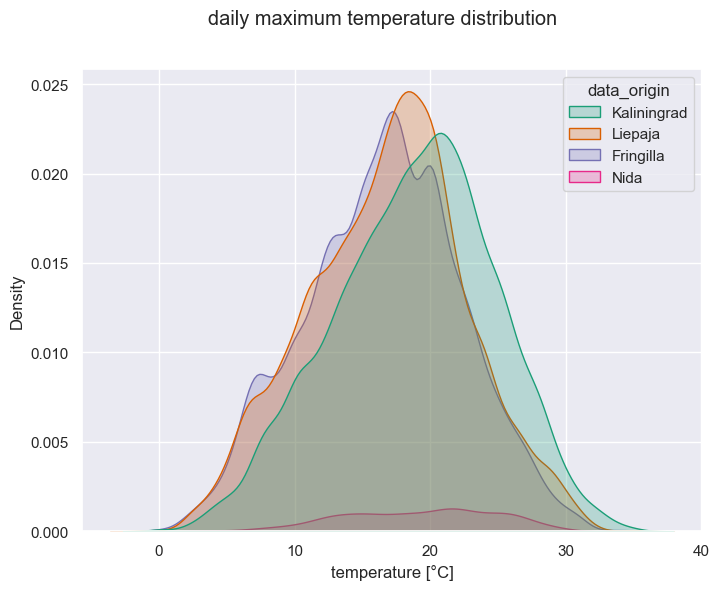

In [152]:
tmp_comparison_short = tmp_comparison[tmp_comparison.year >= 1998]

fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(
    data=tmp_comparison_short[(tmp_comparison_short['data_origin'] != 'Klaipeda')],
    x='tmp',
    hue='data_origin',
    fill=True,
    bw_adjust=0.75,
    ax=ax,
)
ax.set_xlabel('temperature [°C]')
fig.suptitle('daily maximum temperature distribution')
fig.savefig('../figs/temperature-kde.png', 
            dpi=600, bbox_inches='tight')

<AxesSubplot:xlabel='tmp', ylabel='Density'>

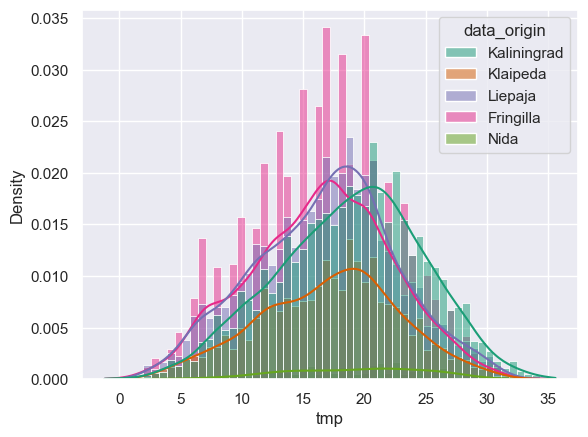

In [153]:
sns.histplot(
    data=tmp_comparison_short,
    x='tmp', hue='data_origin', stat='density', kde=True
)

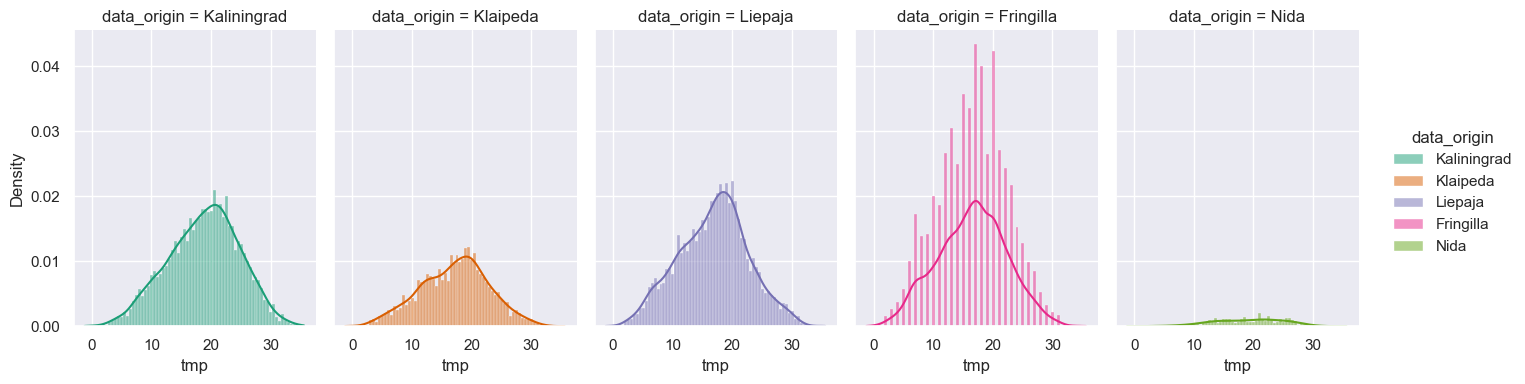

In [154]:
sns.displot(
    data=tmp_comparison_short, x='tmp', hue='data_origin', col='data_origin',
    kind='hist', height=4, aspect=.7, kde=True, binwidth=0.5, stat='density'
)

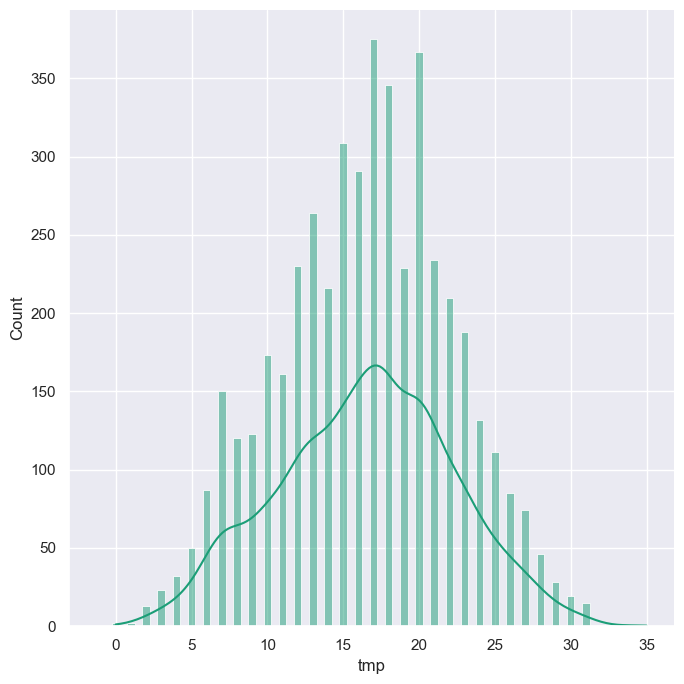

In [155]:
sns.displot(
    data=tmp_comparison_short[tmp_comparison_short.data_origin == 'Fringilla'], 
    x='tmp', height=7, kind='hist', kde=True, binwidth=0.5, binrange=(-1.25, 32.25)
)

### Update 01/06/22

Some ornithologists at Fringilla bird observatory have been using [NCEP R2](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html) climate data, let's dive into this dataset!

In [156]:
from netCDF4 import Dataset
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

In [157]:
ncep = Dataset('../../data/NCEP-R2/tmx/tmax.2m.gauss.1979.nc')
ncep

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    title: Daily NCEP/DOE Reanalysis 2
    comments: Data is from 
NCEP/DOE AMIP-II Reanalysis (Reanalysis-2)
(4x/day).  Data interpolated from model (sigma) surfaces to gaussian grid.
    platform: Model
    source: NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution: National Centers for Environmental Prediction
    dataset_title: NCEP-DOE AMIP-II Reanalysis
    References: https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html
    source_url: http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history: created 2002/03 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2020/05
    dimensions(sizes): lon(192), lat(94), level(1), time(365), nbnds(2)
    variables(dimensions): float32 level(level), float32 lat(lat), float32 lon(lon), float64 time_bnds(time, nbnds), float64 time(time), float32 tmax(time, level, lat, lon)

In [158]:
# variable information
ncep_vars = [var for var in ncep.variables]
for var in ncep_vars:
    print('variable:', ncep.variables[var],'\n')

variable: <class 'netCDF4._netCDF4.Variable'>
float32 level(level)
    units: m
    actual_range: [2. 2.]
    long_name: Level
    positive: up
    axis: Z
    coordinate_defines: point
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    actual_range: [ 88.542 -88.542]
    long_name: Latitude
    standard_name: latitude
    axis: Y
    coordinate_defines: point
unlimited dimensions: 
current shape = (94,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    units: degrees_east
    long_name: Longitude
    actual_range: [  0.    358.125]
    standard_name: longitude
    axis: X
    coordinate_defines: point
unlimited dimensions: 
current shape = (192,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
float64

In [159]:
ncep_lat = ncep.variables['lat'][16:20]
ncep_lon = ncep.variables['lon'][10:14]
ncep_tmx = ncep.variables['tmax'][:,:,16:20,10:14] - 272.15 # convert to °C

Which data point of NCEP is closest to Fringilla?

/home/robi/research/conda_envs/data/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


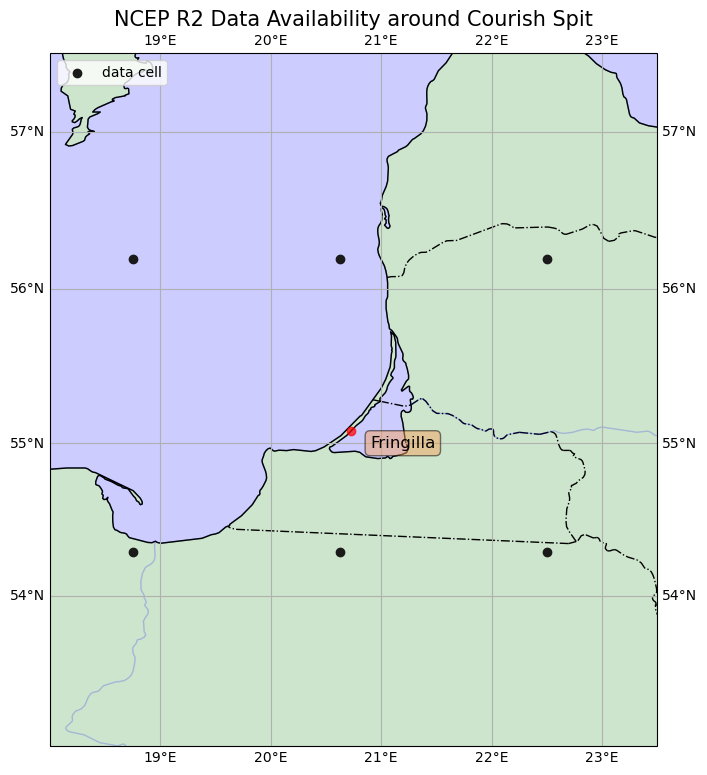

In [160]:
sns.reset_defaults()

# data coordinate system
transform = ccrs.PlateCarree()
# map projection
projection = ccrs.Miller()

fig = plt.figure(figsize=(16,9))
# create a GeoAxes with map projection
ax = plt.axes(projection=projection)

# limit the extent of the map to a longitude/latitude range and add features
ax.set_extent([18, 23.5, 53, 57.5])
ax.add_feature(cfeature.BORDERS, ls='-.')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='green', alpha=0.2)
ax.add_feature(cfeature.OCEAN, color='blue', alpha=0.2)
ax.add_feature(cfeature.RIVERS, color='blue', alpha=0.2)
ax.gridlines(draw_labels=True)

# create mesh from lon & lat
xlon, ylat = np.meshgrid(ncep_lon, ncep_lat)
ax.scatter(xlon, ylat, c='k',
           transform=transform, label='data cell')
ax.legend(loc='upper left')
ax.set_title('NCEP R2 Data Availability around Courish Spit', fontsize=15)

# add a marker for the Fringilla bird observatory
plt.plot(20.73, 55.08, marker='o', color='red', markersize=6,
         alpha=0.7, transform=transform)

# add text
plt.text(20.9, 55.0, 'Fringilla', transform=transform,
         verticalalignment='center', horizontalalignment='left',
         bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'),
         fontsize=12)

fig.savefig('../figs/ncep_data-availability.png', 
            dpi=600, bbox_inches='tight')

### Temperature comparison of NCEP and Fringilla

In [164]:
# coordinates of closest grid points, just to doublecheck...
lat = ncep.variables['lat'][17:19]
lon = ncep.variables['lon'][10:13]

In [165]:
# import daily maximum temperature from all files (one file per year)
# of single data cell which is closest to Fringilla from April to November
ncep_yrs = range(1979, 2022)
tmx = []
for yr in ncep_yrs:
    first_day = (date(yr,4,1) - date(yr, 1, 1)).days
    last_day = (date(yr,11,1) - date(yr, 1, 1)).days
    data = Dataset(f'../../data/NCEP-R2/tmx/tmax.2m.gauss.{yr}.nc')
    tmaxs = data.variables['tmax'][first_day:last_day+1,:,17:19,10:13]
    tmx.append(np.mean(tmaxs) - 272.15)

In [166]:
df_ncep_tmx = pd.DataFrame(
    data=zip(ncep_yrs, ['NCEP']*len(ncep_yrs), tmx), 
    columns=['year', 'data_origin', 'tmp']
)
df_ncep_tmx

,year,data_origin,tmp
0,1979,NCEP,16.435541
1,1980,NCEP,15.645166
2,1981,NCEP,16.176935
3,1982,NCEP,17.081720
4,1983,NCEP,17.733728
5,1984,NCEP,16.975916
6,1985,NCEP,16.544611
7,1986,NCEP,16.779108
8,1987,NCEP,15.406061
9,1988,NCEP,17.057214


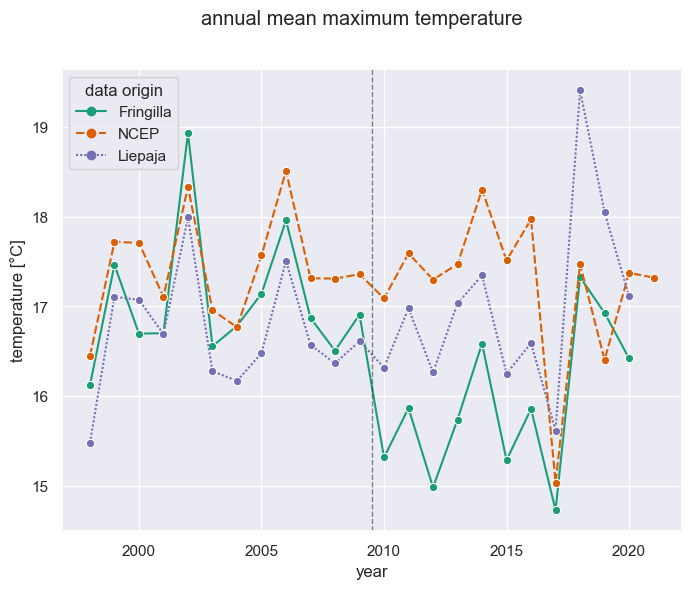

In [167]:
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)
# compare tmp records of Fringilla and NCEP (closest grid point)

# compute annual mean MAX temperature
data = (
    tmp_comparison
    .groupby(['year', 'data_origin'], as_index=False)
    ['tmp'].mean()
)
# and combine with NCEP data
data = pd.concat([data, df_ncep_tmx], axis=0)
# focus on "short" time series
data = data[data.year >= 1998]

fig, ax = plt.subplots(figsize=(8,6))
sns_order = ['Fringilla', 'NCEP', 'Liepaja']
sns.lineplot(
    data=data[data.data_origin.str.contains('Fringilla|Liepaja|NCEP')],
    x='year', y='tmp', hue='data_origin', style='data_origin',
    markers = ['o']*len(sns_order), ax=ax,
    hue_order = sns_order, style_order = sns_order,
)

ax.legend(title='data origin', loc='upper left')
ax.set_ylabel('temperature [°C]')
ax.axvline(x=2009.5, ls='--', lw=1, c='k', alpha=0.5)
fig.suptitle('annual mean maximum temperature')
fig.savefig('../figs/temperature-comparison-ncep.png', 
            dpi=600, bbox_inches='tight')